# Analysis of Generated Sequences

In [1]:
!pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance as levenshtein_distance

In [3]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T", "8HZL"]
base_dir = "./generated_seqs/"
fasta_dir = "./aptamers/fasta/"

In [4]:
def read_fasta(filepath):
    """Read sequences from a FASTA file."""
    sequences = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

def calculate_similarity(seq1, seq2):
    """
    Calculate sequence similarity as 1 - (normalized edit distance).
    Returns a value between 0 (completely different) and 1 (identical).
    """
    max_len = max(len(seq1), len(seq2))
    if max_len == 0:
        return 1.0
    edit_dist = levenshtein_distance(seq1, seq2)
    similarity = 1 - (edit_dist / max_len)
    return similarity

In [7]:
results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")



Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T      8HZL
Sequence                                        
1         0.634146  0.774648  0.244755  0.410714
2         0.609756  0.647887  0.223776  0.404762
3         0.658537  0.788732  0.244755  0.422619
4         0.463415  0.718310  0.251748  0.446429
5         0.609756  0.774648  0.244755  0.452381
6         0.463415  0.760563  0.237762  0.416667
7         0.463415  0.746479  0.251748  0.428571
8         0.414634  0.633803  0.230769  0.416667
9         0.512195  0.661972  0.251748  0.422619
10        0.536585  0.774648  0.244755  0.428571
11        0.585366  0.718310  0.237762  0.428571
12        0.585366  0.690141  0.237762  0.428571
13        0.609756  0.760563  0.244755  0.410714
14        0.536585  0.732394  0.244755  0.416667
15        0.585366  0.704225  0.251748  0.416667
16        0.439024  0.760563  0.237762  0.440476
17        0.585366  0.760563  0.244755  0.452381
18        0.487805  0.704225  0.251748  0.422619
1

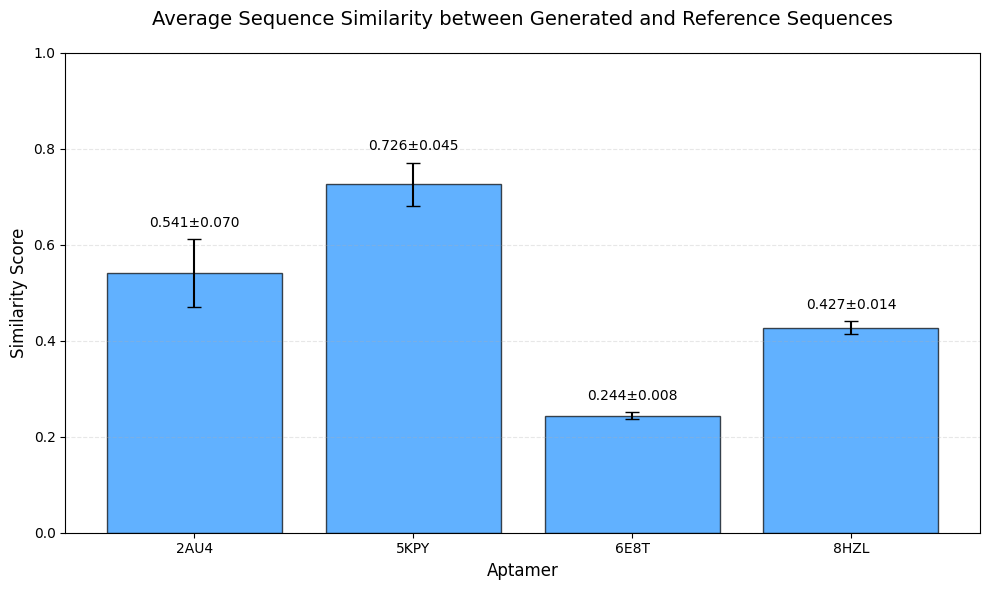

Plot saved as 'similarity_analysis.png'


In [12]:
# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='dodgerblue', edgecolor='black', linewidth=1)

ax.set_xlabel('Aptamer', fontsize=12)
ax.set_ylabel('Similarity Score', fontsize=12,)
ax.set_title('Average Sequence Similarity between Generated and Reference Sequences', 
             fontsize=14, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis.png'")

In [14]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons
8HZL: 190 pairwise comparisons

Self-Similarity Statistics:
             mean       std  count
Aptamer                           
2AU4     0.619641  0.069073    190
5KPY     0.701408  0.050486    190
6E8T     0.621421  0.042553    190
8HZL     0.721648  0.034378    190




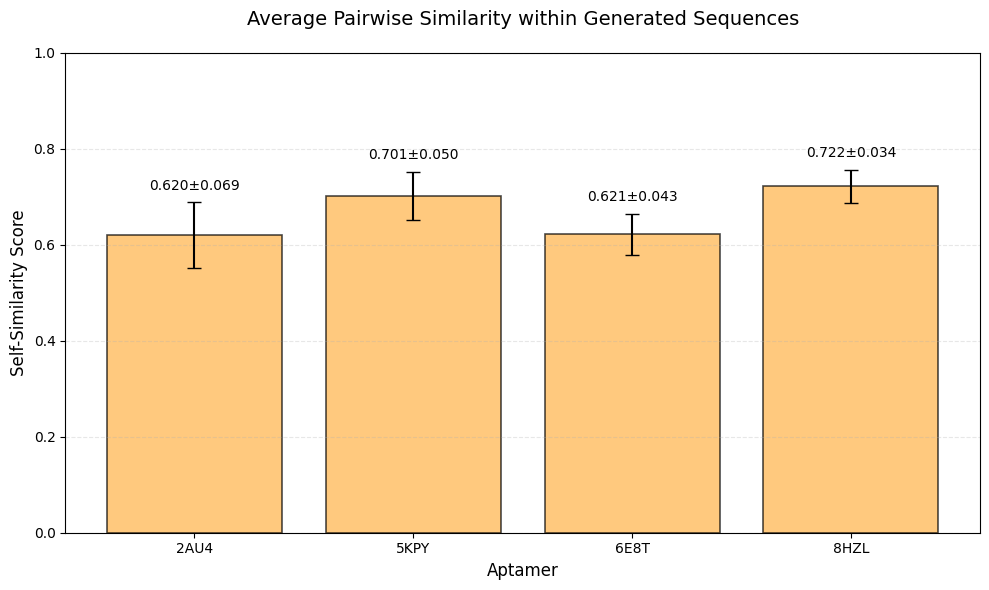

Self-similarity plot saved as 'self_similarity_analysis.png'


In [16]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, 
                color='#FFB347', edgecolor='black', linewidth=1.2)  # Pastel orange

ax2.set_xlabel('Aptamer', fontsize=12)
ax2.set_ylabel('Self-Similarity Score', fontsize=12)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=14, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('self_similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis.png'")